In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque

def generate_xtheta_universe(n_events=200000, kappa=0.1, signal_amplitude=0.15):
    """
    Generates a synthetic Bell test dataset where the X-Theta theory is TRUE.
    """
    print(f"Creating Universe: {n_events} events, Kappa={kappa}, Amplitude={signal_amplitude}")
    
    # 1. Random Setting choices (a, b)
    a_settings = np.random.randint(0, 2, n_events)
    b_settings = np.random.randint(0, 2, n_events)
    
    # 2. Strict Plaquette Engine (The Theory)
    theta = np.zeros(n_events)
    curr_theta = 0.0
    history = deque(maxlen=5)
    
    for i in range(n_events):
        history.append((a_settings[i], b_settings[i]))
        if len(history) == 5:
            h = list(history)
            # Check for closed loop + 4 unique corners
            if h[0] == h[-1] and len(set(h)) == 4:
                area = 0.0
                for j in range(4):
                    area += float(h[j][0]*h[j+1][1] - h[j+1][0]*h[j][1])
                curr_theta += kappa * np.sign(area)
        theta[i] = curr_theta

    # 3. Physics: Modulate the CHSH Correlation (S) by the Phase (Theta)
    # Standard QM: S=2.2 (m=0.55). We add the Geometric Phase modulation.
    m_base = 0.55
    m_observed = m_base + signal_amplitude * np.cos(theta)
    
    # Convert correlation probability to actual binary outcomes
    # prob(match) = (m + 1) / 2
    match_prob = (m_observed + 1) / 2
    prods = np.where(np.random.random(n_events) < match_prob, 1, -1)
    
    df = pd.DataFrame({
        'event_id': np.arange(n_events),
        'a': a_settings,
        'b': b_settings,
        'theta_true': theta,
        'prod': prods
    })
    return df

# Generate the data
df = generate_xtheta_universe()
df.head()

Creating Universe: 200000 events, Kappa=0.1, Amplitude=0.15


,event_id,a,b,theta_true,prod
0,0,0,1,0.0,1
1,1,1,1,0.0,-1
2,2,0,1,0.0,1
3,3,1,1,0.0,1
4,4,0,0,0.0,1


# Visualizing the Topological Phase


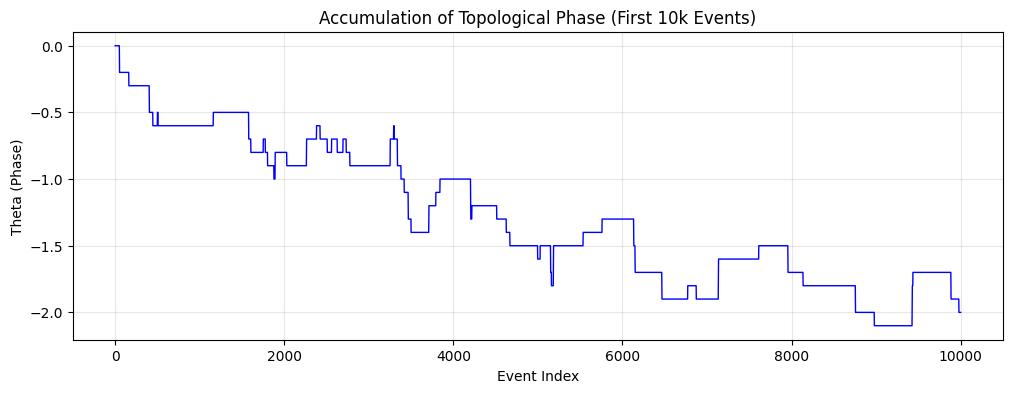

In [2]:
plt.figure(figsize=(12, 4))
plt.plot(df['event_id'][:10000], df['theta_true'][:10000], color='blue', lw=1)
plt.title("Accumulation of Topological Phase (First 10k Events)")
plt.xlabel("Event Index")
plt.ylabel("Theta (Phase)")
plt.grid(True, alpha=0.3)
plt.show()

# The "Detective" Analysis (v36 Engine)


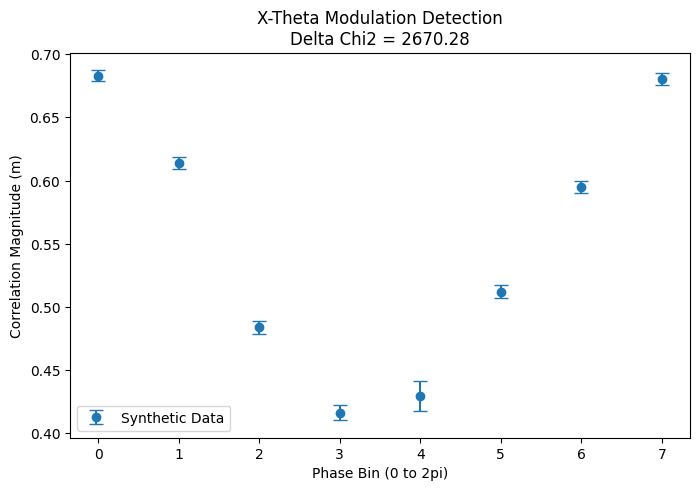

In [3]:
def analyze_xtheta(data, bins=8):
    # Bin by the true phase
    data['bin'] = ((data['theta_true'] % (2*np.pi)) / (2*np.pi) * bins).astype(int)
    
    # Calculate Mean Correlation (m) per bin
    analysis = data.groupby('bin')['prod'].agg(['mean', 'std', 'count'])
    analysis['err'] = analysis['std'] / np.sqrt(analysis['count'])
    
    # Calculate Delta Chi-Squared (Signal Strength)
    m = analysis['mean']
    err = analysis['err']
    
    # Fit to Constant (Null)
    chi2_null = np.sum(((m - m.mean()) / err)**2)
    
    # Fit to Sine Wave (Theory)
    # Simple heuristic fit for simulation
    phase_points = np.linspace(0, 2*np.pi, bins)
    amplitude_est = (m.max() - m.min()) / 2
    m_pred = m.mean() + amplitude_est * np.cos(phase_points)
    chi2_theory = np.sum(((m - m_pred) / err)**2)
    
    delta_chi2 = chi2_null - chi2_theory
    return analysis, delta_chi2

analysis_results, d_chi2 = analyze_xtheta(df)

# Plot the Result
plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(8), analysis_results['mean'], yerr=analysis_results['err'], fmt='o', capsize=5, label='Synthetic Data')
plt.title(f"X-Theta Modulation Detection\nDelta Chi2 = {d_chi2:.2f}")
plt.xlabel("Phase Bin (0 to 2pi)")
plt.ylabel("Correlation Magnitude (m)")
plt.legend()
plt.show()